## 1. Place Human, Furnitures in the Mujoco Simulator

In [1]:

import sys,mujoco,time,os,json
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../package/helper/')
sys.path.append('../package/mujoco_usage/')
sys.path.append('../package/gpt_usage/')
sys.path.append('../package/detection_module/')
from mujoco_parser import *
from utility import *
from transformation import *
from gpt_helper import *
from owlv2 import *
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

# Joint configuration
joint_names = ['shoulder_pan_joint','shoulder_lift_joint','elbow_joint',
               'wrist_1_joint','wrist_2_joint','wrist_3_joint']
print ("Ready.")

Ready.
Ready.


In [2]:
xml_path = '../asset/makeup_frida/scene_table.xml'
env = MuJoCoParserClass(name='Tabletop',rel_xml_path=xml_path,verbose=True)
print ("Done.")
# Solve IK to get the initial position 


env.reset()
env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
q_init,ik_err_stack,ik_info = solve_ik(
    env = env,
    joint_names_for_ik = joint_names,
    body_name_trgt     = 'ur_camera_center',
    q_init       = np.deg2rad([0,0,0,0,0,0]), # ik from zero pose
    p_trgt       = np.array([0.41,0.0,1.2]),
    R_trgt       = rpy2r(np.deg2rad([-135.22,-0.,-90])),
    max_ik_tick  = 5000,
    ik_err_th    = 1e-4,
    ik_stepsize  = 0.1,
    ik_eps       = 1e-2,
    ik_th        = np.radians(1.0),
    verbose      = False,
    reset_env    = False,
    render       = False,
    render_every = 1,
)
print ("Done.")

name:[Tabletop] dt:[0.002] HZ:[500]
n_qpos:[54] n_qvel:[48] n_qacc:[48] n_ctrl:[7]

n_body:[34]
 [0/34] [world] mass:[0.00]kg
 [1/34] [base_table] mass:[100.00]kg
 [2/34] [object_table] mass:[100.00]kg
 [3/34] [ur_base] mass:[4.00]kg
 [4/34] [ur_shoulder_link] mass:[3.70]kg
 [5/34] [ur_upper_arm_link] mass:[8.39]kg
 [6/34] [ur_forearm_link] mass:[2.27]kg
 [7/34] [ur_wrist_1_link] mass:[1.22]kg
 [8/34] [ur_wrist_2_link] mass:[1.22]kg
 [9/34] [ur_wrist_3_link] mass:[0.19]kg
 [10/34] [ur_tcp_link] mass:[0.00]kg
 [11/34] [ur_camera_mount] mass:[0.09]kg
 [12/34] [ur_d435i] mass:[0.07]kg
 [13/34] [ur_rg2_gripper_base_link] mass:[0.20]kg
 [14/34] [ur_camera_center] mass:[0.00]kg
 [15/34] [ur_rg2_gripper_finger1_finger_link] mass:[0.01]kg
 [16/34] [ur_rg2_gripper_finger1_inner_knuckle_link] mass:[0.01]kg
 [17/34] [ur_rg2_gripper_finger1_finger_tip_link] mass:[0.01]kg
 [18/34] [ur_rg2_gripper_finger2_finger_link] mass:[0.01]kg
 [19/34] [ur_rg2_gripper_finger2_inner_knuckle_link] mass:[0.01]kg
 

Object list:
 [0] obj_name:[obj_head]


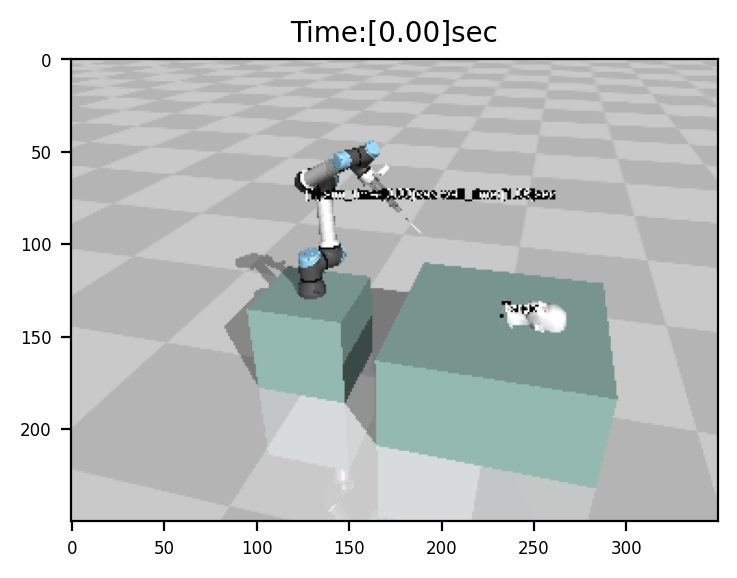

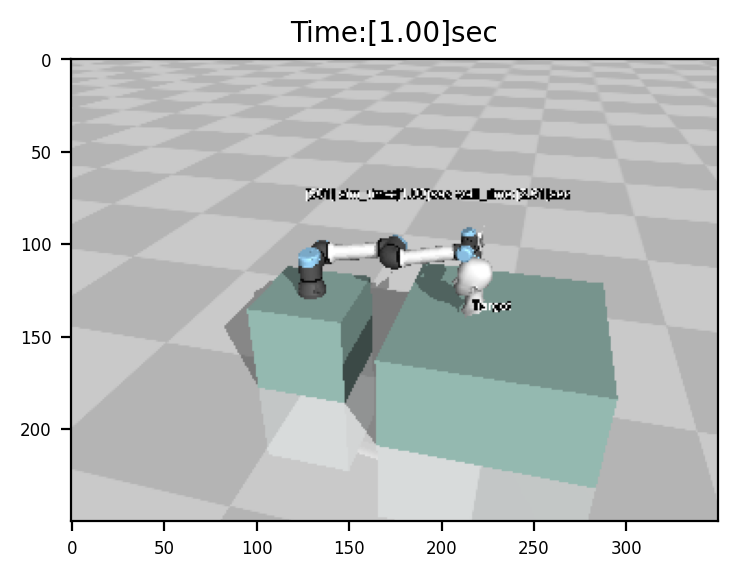

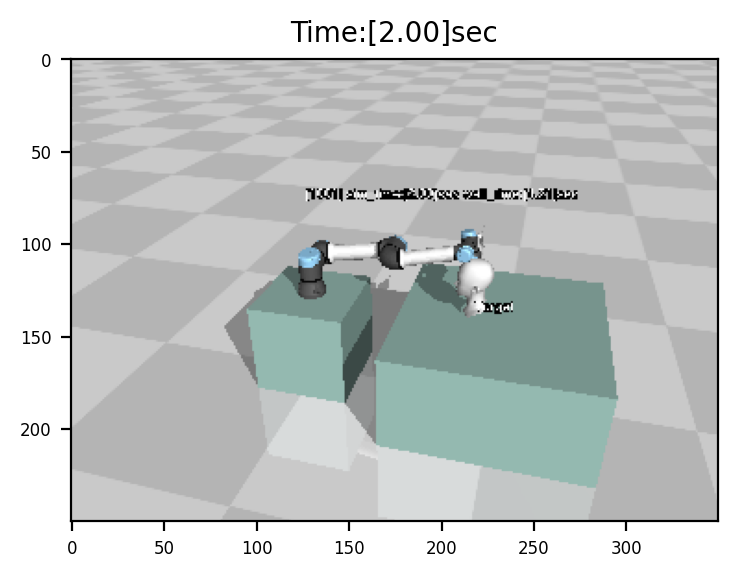

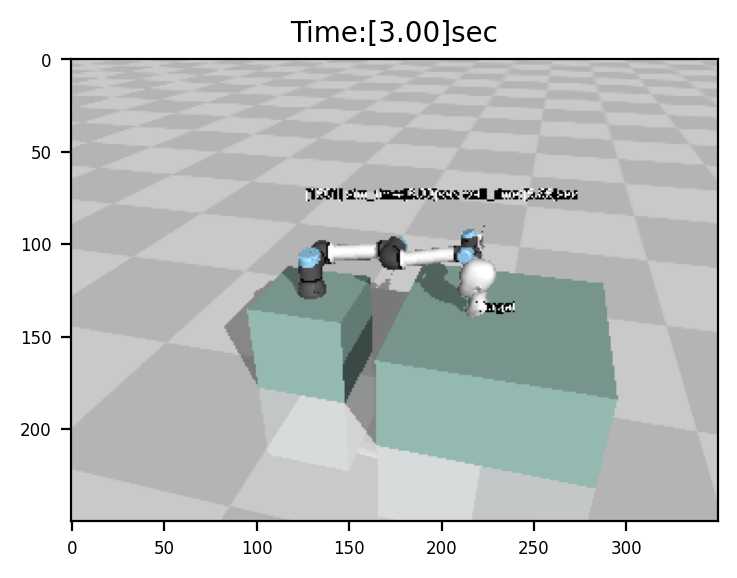

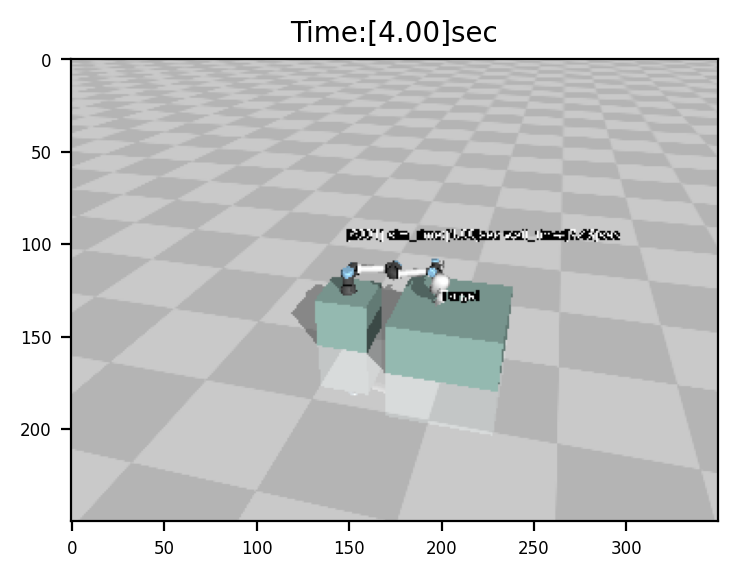

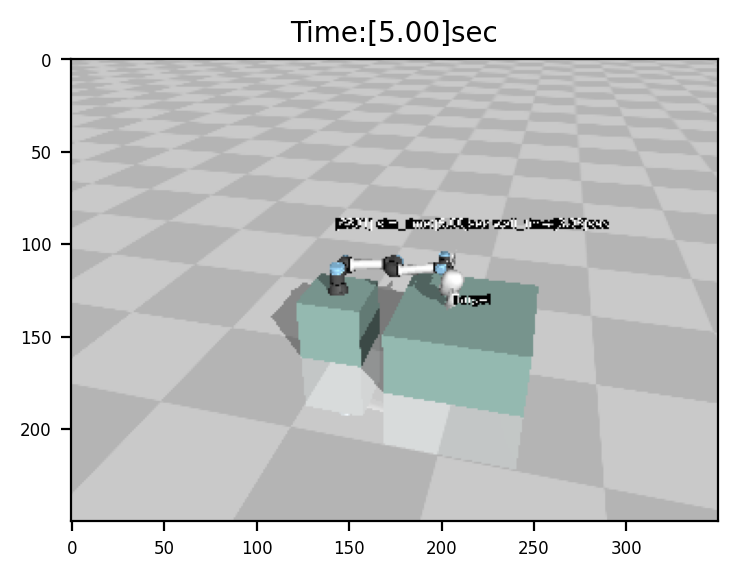

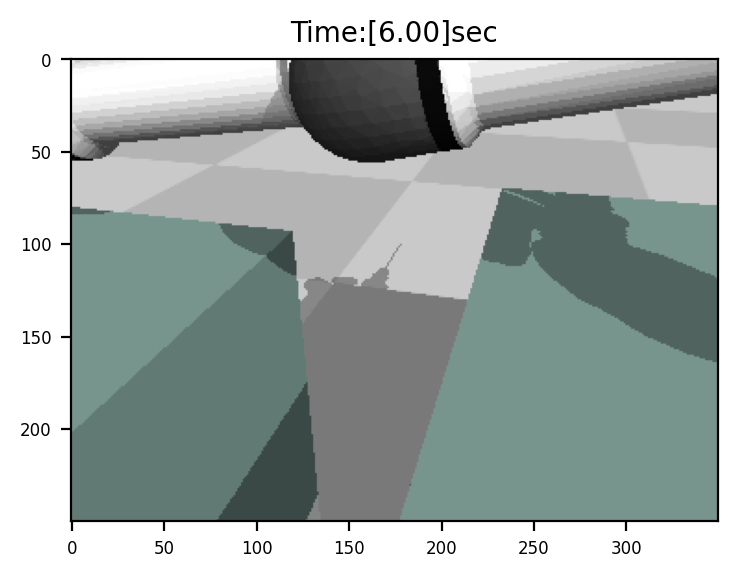

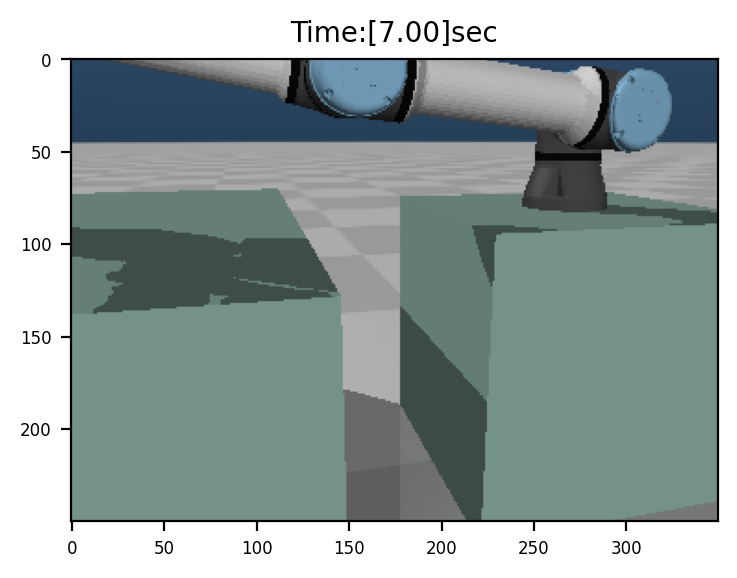

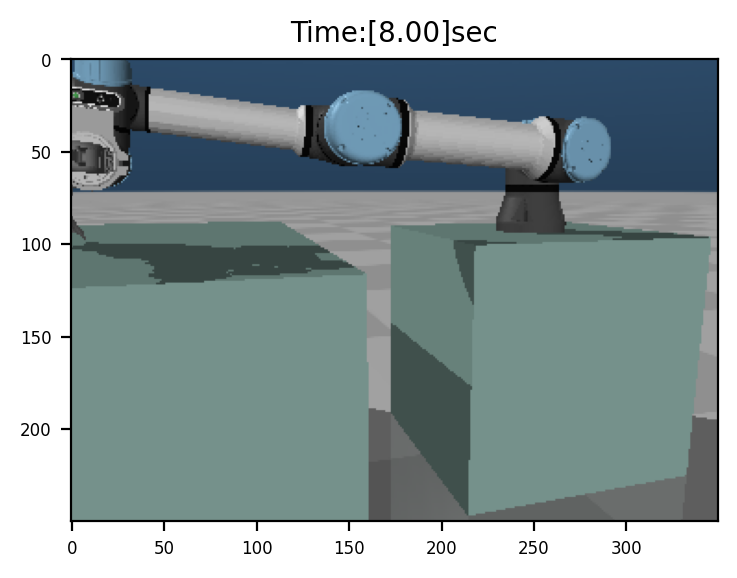

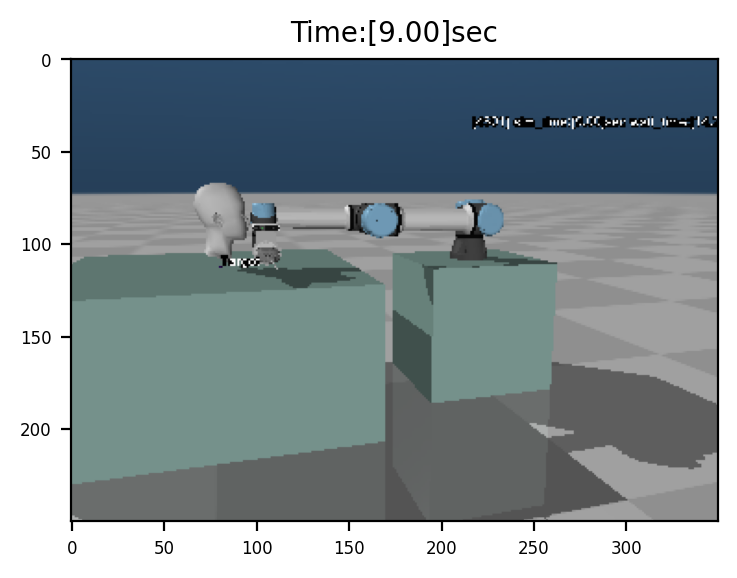

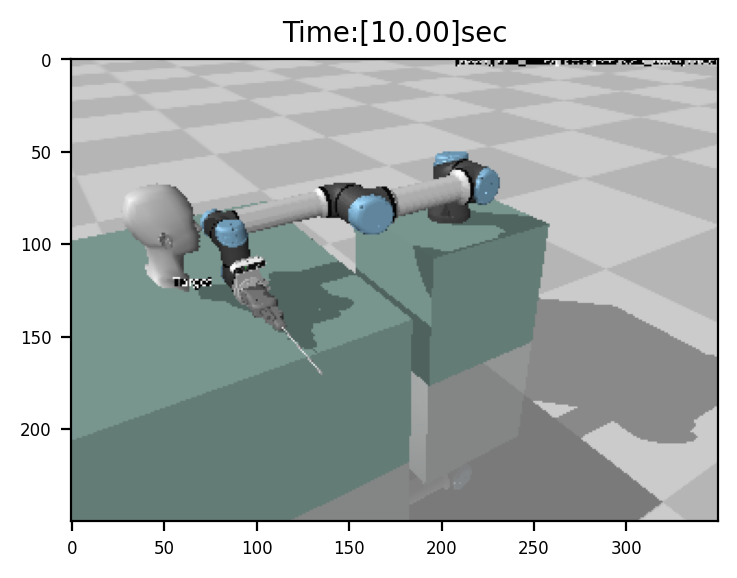

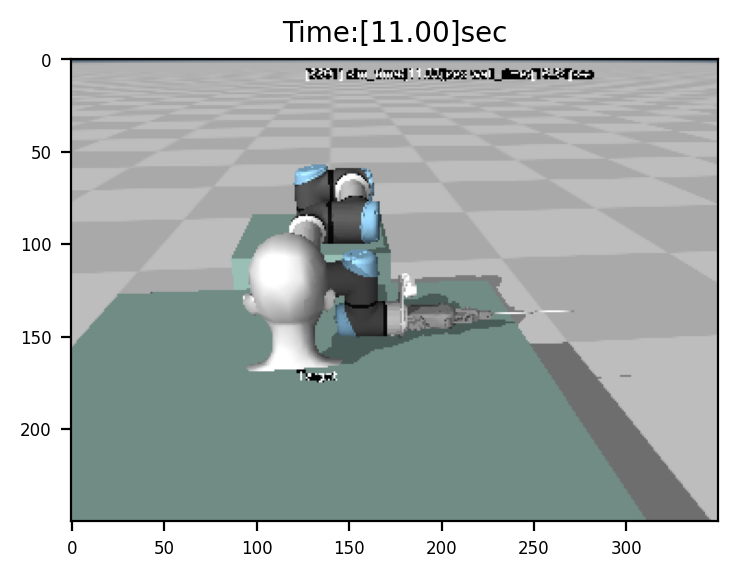

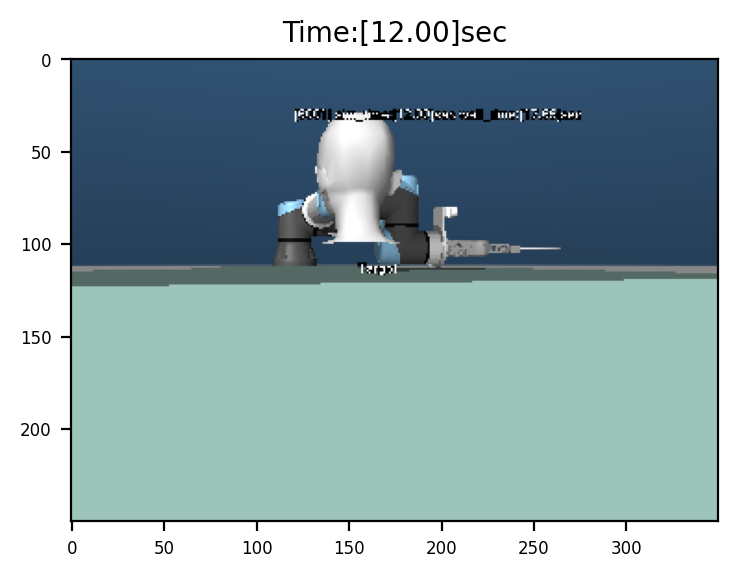

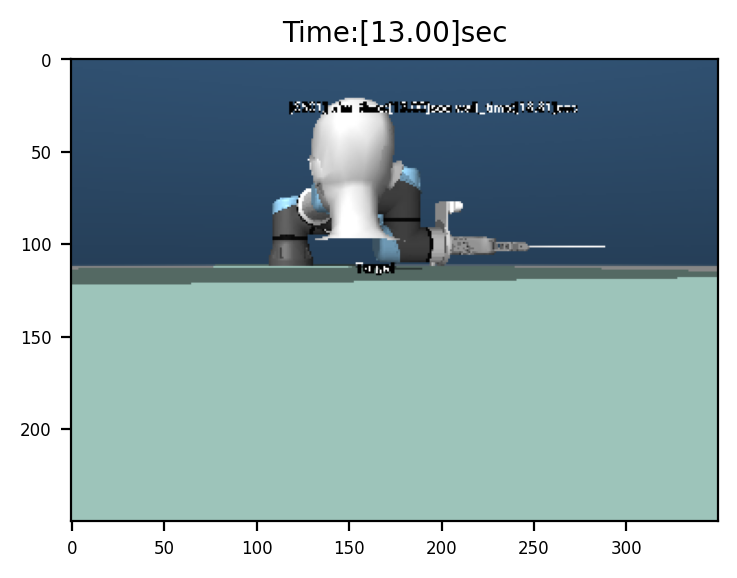

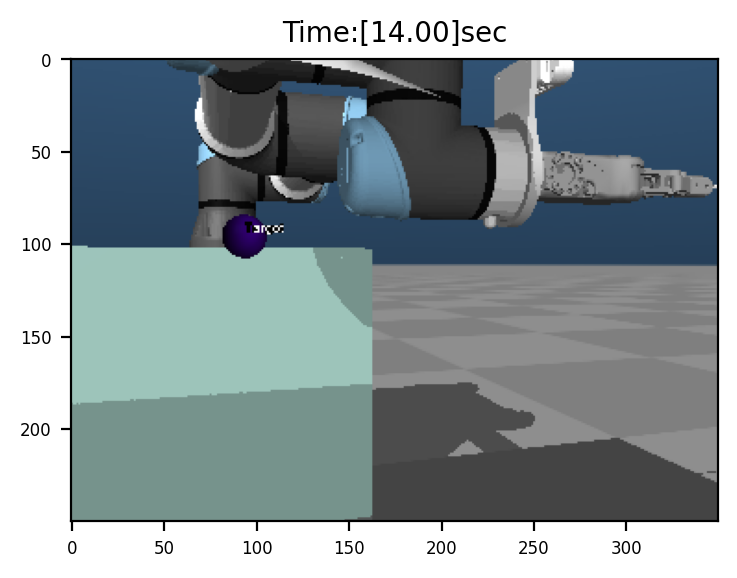

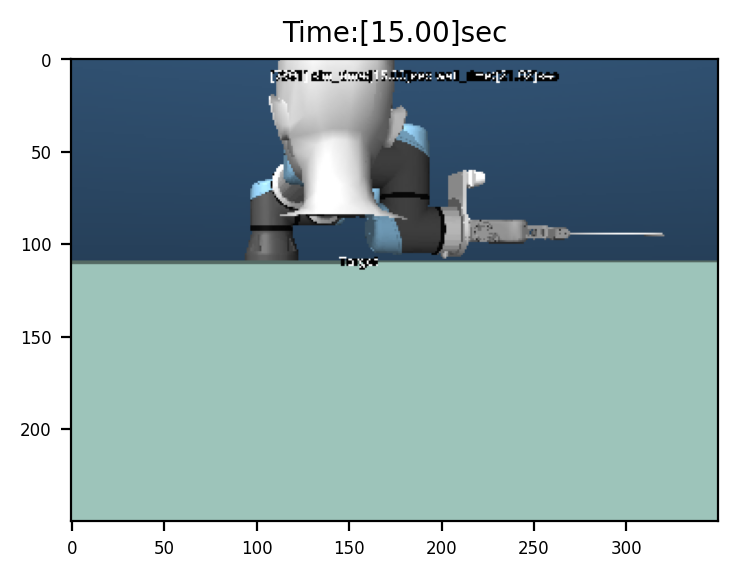

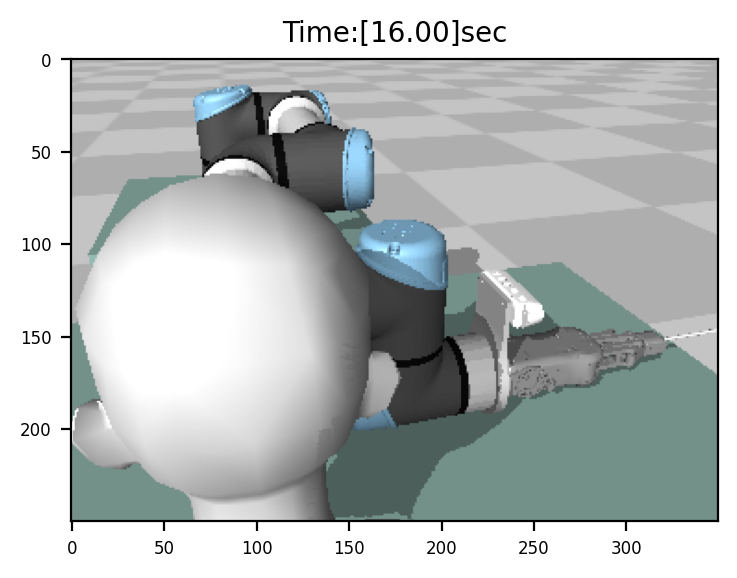

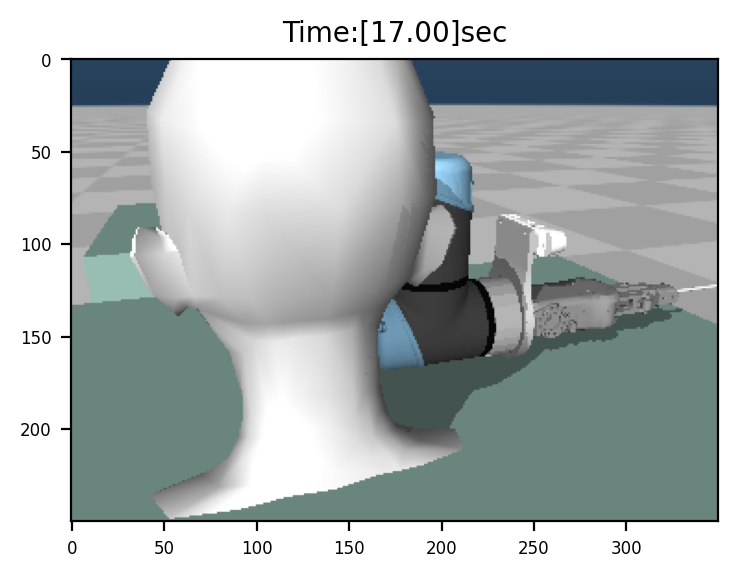

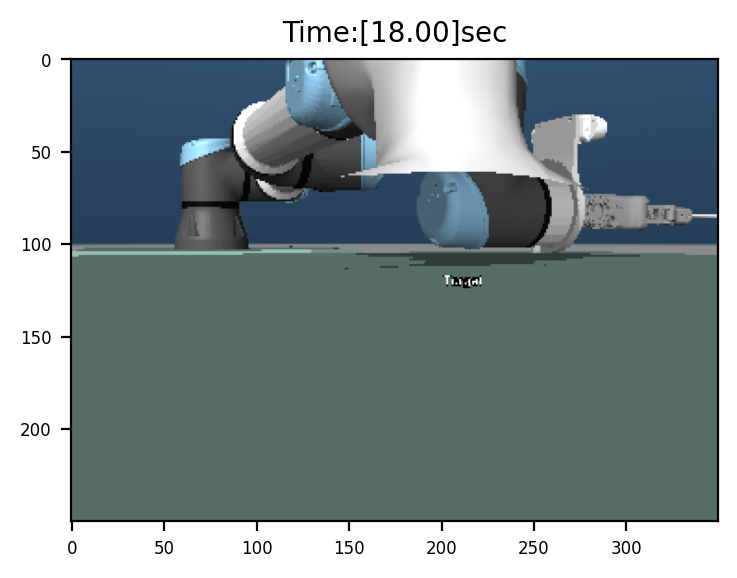

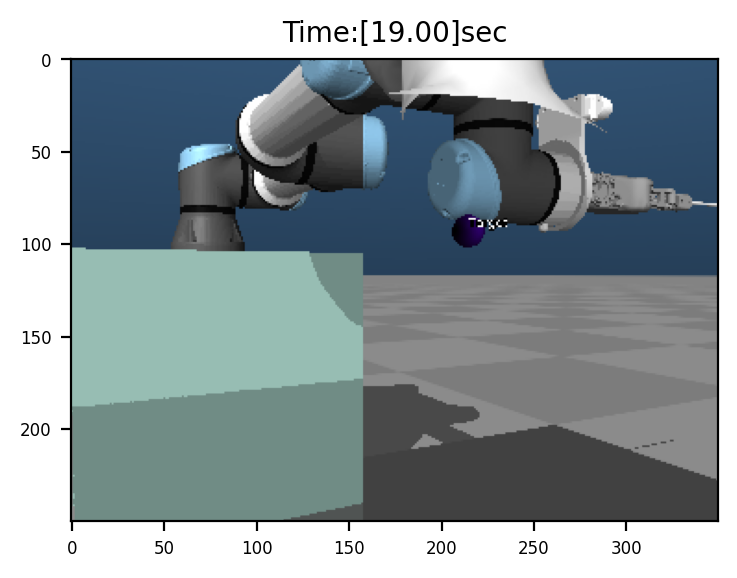

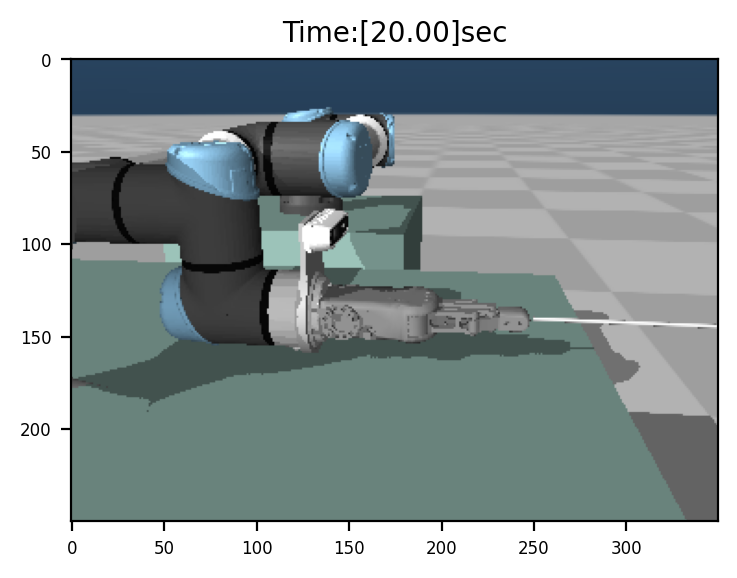

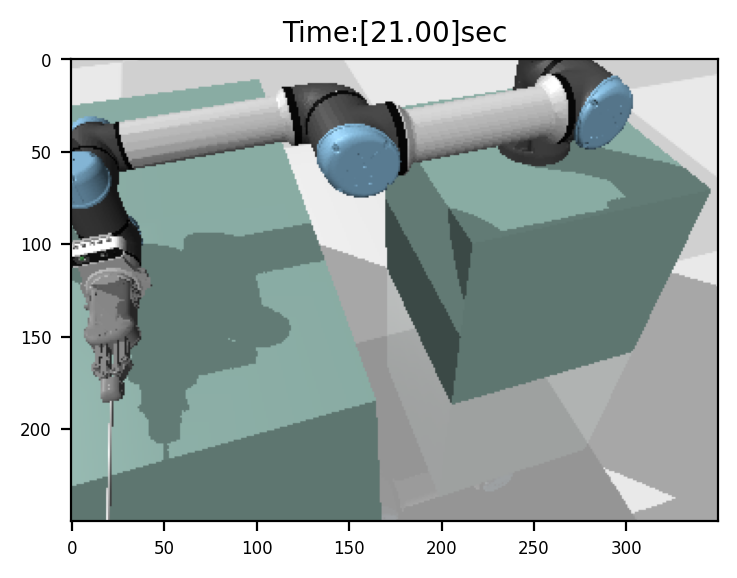

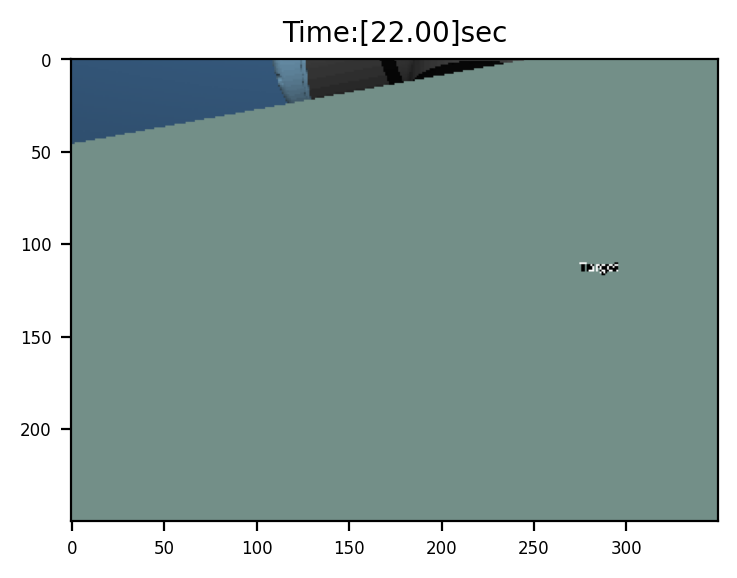

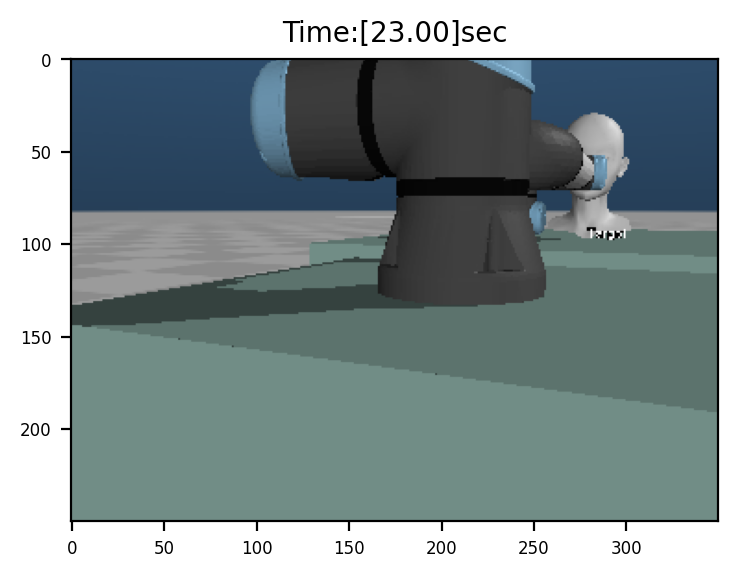

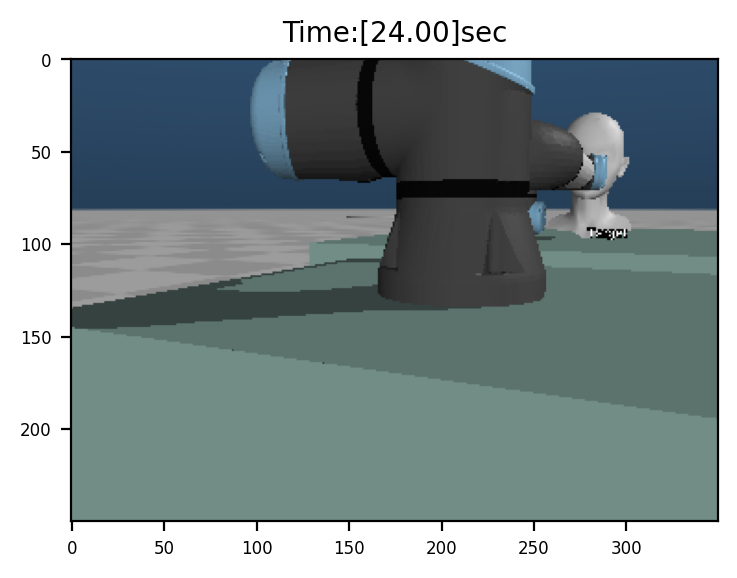

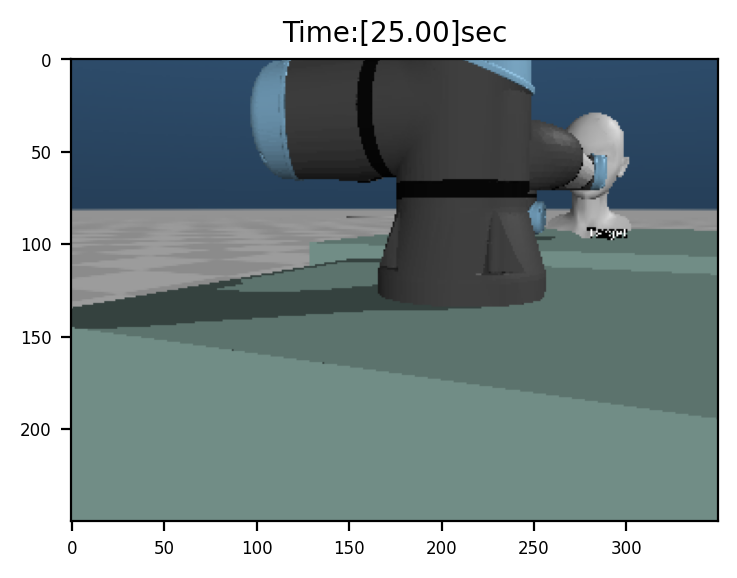

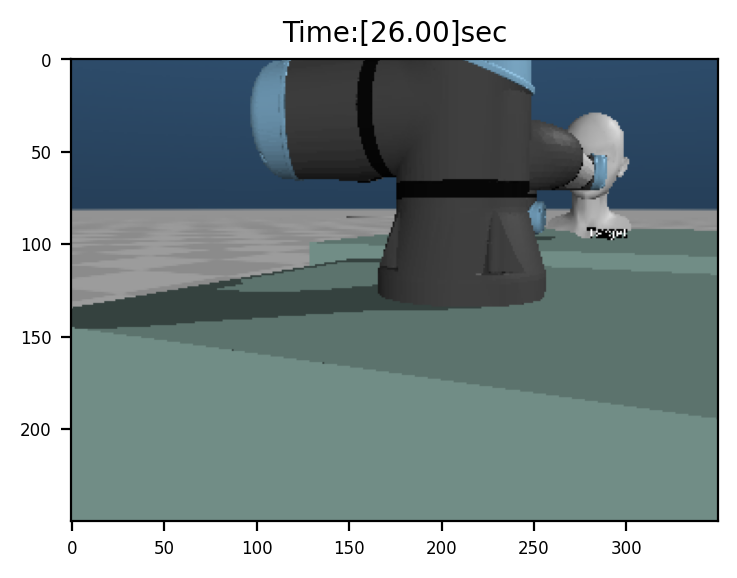

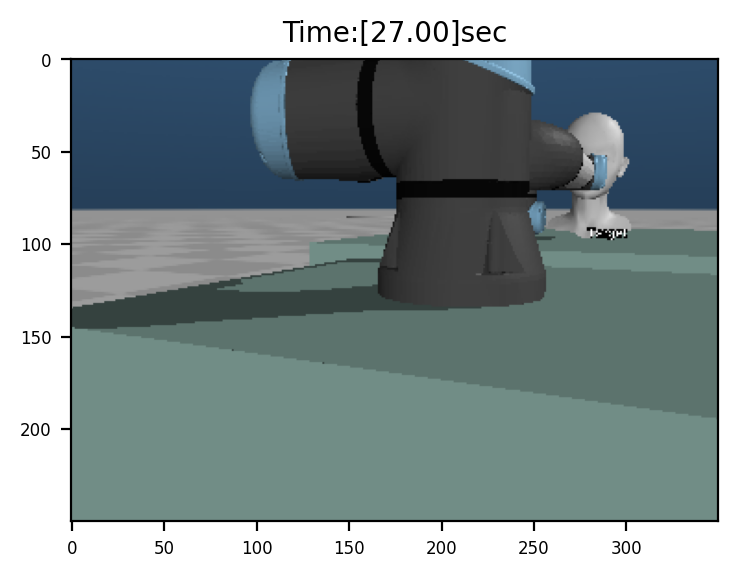

Done.


In [3]:
# Initialize environment

# Initialize viewer
env.reset()
env.init_viewer(
    transparent=False,
    azimuth=105,
    distance=3.12,
    elevation=-29,
    lookat=[0.39, 0.25, 0.43],
)

env.set_p_body(body_name='ur_base',p=np.array([0,0,0.5])) # move UR
env.set_p_body(body_name='object_table',p=np.array([1.0,0,0])) # move table
# obj_names = env.get_body_names(prefix='obj_') # object names
obj_names = ['obj_head']
n_obj = len(obj_names)
obj_xyzs = sample_xyzs(
    n_obj,
    x_range   = [0.75,1.25],
    y_range   = [-0.4,+0.4],
    z_range   = [0.51,0.51],
    min_dist  = 0.1,
    xy_margin = 0.0
)
obj_xyzs = np.array([[1, 0, 0.51]])
R = rpy2r(np.radians([0,0,270]))
print ("Object list:")
for obj_idx in range(n_obj):
    print (" [%d] obj_name:[%s]"%(obj_idx,obj_names[obj_idx]))
    env.set_p_base_body(body_name=obj_names[obj_idx],p=obj_xyzs[obj_idx,:])
    env.set_R_base_body(body_name=obj_names[obj_idx],R=R)
# Move
qpos = np.radians([0,-90,60,75,90,0])
idxs_step = env.get_idxs_step(joint_names=joint_names)
env.set_qpos_joints(joint_names=joint_names,qpos=q_init)

# Main loop
env_state = env.get_state()
while env.is_viewer_alive():
    # Step
    env.step()
    p_target = env.get_p_body('obj_head')  # Get end-effector position at target
    
    # Add target marker

    # Render
    if env.loop_every(tick_every=20):
        env.plot_sphere(p=p_target, r=0.01, rgba=(1,0,1,1), label='Target')
        env.plot_time()
        env.render()
    
    # Plot
    if env.loop_every(tick_every=500):  # every 1 second
        # Grab current view
        render_img = env.grab_image(rsz_rate=1/4)
        # Plot
        plt.figure(figsize=(8, 3))
        plt.imshow(render_img)
        plt.title(f"Time:[{env.get_sim_time():.2f}]sec", fontsize=10)
        plt.show()
        

env.close_viewer()
print ("Done.")
